# Лаба 6
Работаем

Импорт библиотек, закачка сета

In [4]:
import kagglehub
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [5]:
path = kagglehub.dataset_download("pooriamst/metro-interstate-traffic-volume")

print("Path to dataset files:", path)

Path to dataset files: /home/blbej/.cache/kagglehub/datasets/pooriamst/metro-interstate-traffic-volume/versions/1


In [6]:
PATH = f"{path}/Metro_Interstate_Traffic_Volume.csv"

## Описание столбцов

- **`date_time`** — временная метка наблюдения (дата и час).
- **`traffic_volume`** — целевая переменная: интенсивность трафика (количество автомобилей за час). 

### Погодные числовые признаки
- **`temp`** — температура **в Кельвинах**.   
- **`rain_1h`** — количество дождя за последний час (обычно **мм**).   
- **`snow_1h`** — количество снега за последний час (обычно **мм**).   
- **`clouds_all`** — облачность, **процент покрытия неба** (0–100).   

### Погодные категориальные признаки
- **`weather_main`** — краткая категория погоды (например, `Clouds`, `Rain`, `Snow`, `Thunderstorm`).   
- **`weather_description`** — более подробное текстовое описание (например, `overcast clouds`, `light rain`).   

### Праздники
- **`holiday`** — название праздника, если дата относится к празднику; иначе пусто/`NaN` (в дальнейшем будем заменять на `Unknown` для удобства).   

In [10]:
df = pd.read_csv(PATH)

df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


## Некст проблем that we have это неравномерное распределение времени.

In [6]:
df["date_time"] = pd.to_datetime(df["date_time"])
df = df.sort_values("date_time")
df["time_diff"] = df["date_time"].diff()

print("\nРаспределение интервалов (часы):")
intervals_hours = df['time_diff'].dt.total_seconds() / 3600
value_counts = intervals_hours.value_counts().sort_index()
print(value_counts.head(10))


Распределение интервалов (часы):
time_diff
0.0     7629
1.0    37986
2.0     2192
3.0      201
4.0       59
5.0       33
6.0       17
7.0       10
8.0       13
9.0       12
Name: count, dtype: int64


## Для начала объеденим все данные с одинаковым временным индексом. Будем брать среднее и моду объединяемых ячеек.

In [ ]:
num_cols = ["temp","rain_1h","snow_1h","clouds_all","traffic_volume"]
cat_cols = ["weather_main","weather_description"]

def mode_or_nan(s):
    s = s.dropna()
    if s.empty: return np.nan
    m = s.mode()
    return m.iloc[0] if not m.empty else np.nan

df = (df.groupby("date_time", as_index=False)
        .agg({
            **{c:"mean" for c in num_cols},
            **{c:mode_or_nan for c in cat_cols},
            "holiday": lambda s: s.dropna().iloc[0] if s.dropna().shape[0] else np.nan
        }))

df

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weather_main,weather_description,holiday
0,2012-10-02 09:00:00,288.28,0.0,0.0,40.0,5545.0,Clouds,scattered clouds,NaN
1,2012-10-02 10:00:00,289.36,0.0,0.0,75.0,4516.0,Clouds,broken clouds,NaN
2,2012-10-02 11:00:00,289.58,0.0,0.0,90.0,4767.0,Clouds,overcast clouds,NaN
3,2012-10-02 12:00:00,290.13,0.0,0.0,90.0,5026.0,Clouds,overcast clouds,NaN
4,2012-10-02 13:00:00,291.14,0.0,0.0,75.0,4918.0,Clouds,broken clouds,NaN
...,...,...,...,...,...,...,...,...,...
40570,2018-09-30 19:00:00,283.45,0.0,0.0,75.0,3543.0,Clouds,broken clouds,NaN
40571,2018-09-30 20:00:00,282.76,0.0,0.0,90.0,2781.0,Clouds,overcast clouds,NaN
40572,2018-09-30 21:00:00,282.73,0.0,0.0,90.0,2159.0,Thunderstorm,proximity thunderstorm,NaN
40573,2018-09-30 22:00:00,282.09,0.0,0.0,90.0,1450.0,Clouds,overcast clouds,NaN


In [ ]:
df["time_diff"] = df["date_time"].diff()

print("\nРаспределение интервалов (часы):")
intervals_hours = df['time_diff'].dt.total_seconds() / 3600
value_counts = intervals_hours.value_counts().sort_index()
print(value_counts.head(10))


Распределение интервалов (часы):
time_diff
1.0     37986
2.0      2192
3.0       201
4.0        59
5.0        33
6.0        17
7.0        10
8.0        13
9.0        12
10.0       13
Name: count, dtype: int64


## Далее займёмся большими интервалами(больше часа).

### Для новых ячеек:
- Температуру и облачность интерполируем.
- Осадки обнуляем.
- Кат. признаки указываем как неизвестные.

In [59]:
df = df.set_index("date_time").sort_index()
full_idx = pd.date_range(df.index.min(), df.index.max(), freq="H")
df = df.reindex(full_idx)
df.index.name = "date_time"

df["was_missing_time"] = df["traffic_volume"].isna().astype(int)

/tmp/ipykernel_35337/3828662499.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(df.index.min(), df.index.max(), freq="H")


In [60]:
df["temp"] = df["temp"].interpolate("time")
df["clouds_all"] = df["clouds_all"].interpolate("time")
df["rain_1h"] = df["rain_1h"].fillna(0)
df["snow_1h"] = df["snow_1h"].fillna(0)

for c in ["weather_main","weather_description","holiday"]:
    df[c] = df[c].ffill().fillna("Unknown")

df

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weather_main,weather_description,holiday,time_diff,was_missing_time
date_time,,,,,,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40.0,5545.0,Clouds,scattered clouds,Unknown,NaT,0
2012-10-02 10:00:00,289.36,0.0,0.0,75.0,4516.0,Clouds,broken clouds,Unknown,0 days 01:00:00,0
2012-10-02 11:00:00,289.58,0.0,0.0,90.0,4767.0,Clouds,overcast clouds,Unknown,0 days 01:00:00,0
2012-10-02 12:00:00,290.13,0.0,0.0,90.0,5026.0,Clouds,overcast clouds,Unknown,0 days 01:00:00,0
2012-10-02 13:00:00,291.14,0.0,0.0,75.0,4918.0,Clouds,broken clouds,Unknown,0 days 01:00:00,0
...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,283.45,0.0,0.0,75.0,3543.0,Clouds,broken clouds,Labor Day,0 days 01:00:00,0
2018-09-30 20:00:00,282.76,0.0,0.0,90.0,2781.0,Clouds,overcast clouds,Labor Day,0 days 01:00:00,0
2018-09-30 21:00:00,282.73,0.0,0.0,90.0,2159.0,Thunderstorm,proximity thunderstorm,Labor Day,0 days 01:00:00,0


In [66]:
diff = df.index.diff()

print("\nРаспределение интервалов (часы):")
intervals_hours = diff.total_seconds() / 3600
value_counts = intervals_hours.value_counts().sort_index()
print(value_counts.head(10))


Распределение интервалов (часы):
date_time
1.0    52550
Name: count, dtype: int64


Напоследок:
* Распредилим праздники по всем временным индексам дня(раньше было только в 00:00).
* Ограничим кол-во категориальных признаков погоды(проклятие размерности ууу...)

In [68]:
df = df.drop(columns=["time_diff"])

df["holiday"] = df["holiday"].astype(str)

def day_holiday(s):
    s2 = s.replace("Unknown", np.nan).dropna()
    return s2.iloc[0] if len(s2) else "Unknown"

df["holiday"] = df.groupby(df.index.normalize())["holiday"].transform(day_holiday)
df["is_holiday"] = (df["holiday"] != "Unknown").astype(int)

topk = 30
top_vals = df["weather_description"].value_counts().head(topk).index
df["weather_description"] = np.where(df["weather_description"].isin(top_vals),
                                     df["weather_description"], "Other")

for c in ["weather_main", "weather_description", "holiday"]:
    df[c] = df[c].astype(str).fillna("Unknown")

df

/tmp/ipykernel_35337/2854146501.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  s2 = s.replace("Unknown", np.nan).dropna()


,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weather_main,weather_description,holiday,was_missing_time,is_holiday
date_time,,,,,,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40.0,5545.0,Clouds,scattered clouds,Unknown,0,0
2012-10-02 10:00:00,289.36,0.0,0.0,75.0,4516.0,Clouds,broken clouds,Unknown,0,0
2012-10-02 11:00:00,289.58,0.0,0.0,90.0,4767.0,Clouds,overcast clouds,Unknown,0,0
2012-10-02 12:00:00,290.13,0.0,0.0,90.0,5026.0,Clouds,overcast clouds,Unknown,0,0
2012-10-02 13:00:00,291.14,0.0,0.0,75.0,4918.0,Clouds,broken clouds,Unknown,0,0
...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,283.45,0.0,0.0,75.0,3543.0,Clouds,broken clouds,Labor Day,0,1
2018-09-30 20:00:00,282.76,0.0,0.0,90.0,2781.0,Clouds,overcast clouds,Labor Day,0,1
2018-09-30 21:00:00,282.73,0.0,0.0,90.0,2159.0,Thunderstorm,proximity thunderstorm,Labor Day,0,1


## `make_features`

Функция готовит признаки для прогноза `traffic_volume`:

- добавляет календарные фичи из времени: `hour`, `dow`, `month`, `is_weekend`;
- кодирует цикличность времени через `sin/cos` для часа и дня недели;
- создаёт лаги `lag_k = y(t-k)` для заданных `lags`;
- считает rolling-статистики (`mean`, `std`) по прошлым значениям (через `shift(1)`, чтобы не было утечки);
- формирует таргет `y = traffic_volume(t+1)` (one-step прогноз).

In [ ]:
def make_features(data: pd.DataFrame,
                  target_col="traffic_volume",
                  lags=(1,2,3,6,12,24,48,72,168),
                  rolls=(3,6,24,168)) -> pd.DataFrame:
    df = data.copy()

    dt = df.index
    df["hour"] = dt.hour
    df["dow"] = dt.dayofweek
    df["month"] = dt.month
    df["is_weekend"] = (df["dow"] >= 5).astype(int)

    df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
    df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
    df["dow_sin"]  = np.sin(2*np.pi*df["dow"]/7)
    df["dow_cos"]  = np.cos(2*np.pi*df["dow"]/7)

    for l in lags:
        df[f"lag_{l}"] = df[target_col].shift(l)

    base = df[target_col].shift(1)
    for w in rolls:
        df[f"roll_mean_{w}"] = base.rolling(w).mean()
        df[f"roll_std_{w}"]  = base.rolling(w).std()

    df["y"] = df[target_col].shift(-1)

    return df


## Обучение CatBoost

1. Генерируем признаки (календарные фичи + лаги/роллинги) через `make_features(df)`.
2. Удаляем строки без таргета: `dropna(subset=["y"])` (без `y` нельзя считать лосс).
3. Разделяем признаки/таргет: `X = feat.drop("y")`, `y = feat["y"]`.
4. Категориальные столбцы (`weather_main`, `weather_description`, `holiday`) приводим к строкам и передаём в CatBoost как `cat_features`.
5. Делаем time-based split: первые 80% — train, последние 20% — test (без перемешивания).
6. Обучаем `CatBoostRegressor` с early stopping (`od_wait=100`) на валидации `test_pool`.
7. Предсказываем на тесте и считаем метрики качества: RMSE, MAE, R².

### Обобщая, мы используем выборку с интерполированными данными, дабы получить непрерывные лаги для catboost, но удаляем интерполированные ячейки уже при обучении(у одной ячейки могут отсутствовать значения по некоторым лагам, но таргет обязан быть).

In [75]:
feat = make_features(df)

feat = feat.dropna(subset=["y"])

cat_features = ["weather_main", "weather_description", "holiday"]
drop_cols = ["y"]

X = feat.drop(columns=drop_cols)
y = feat["y"]

for c in cat_features:
    X[c] = X[c].astype(str)

split_idx = int(len(feat) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_features)

model = CatBoostRegressor(
    loss_function="RMSE",
    eval_metric="RMSE",
    iterations=3000,
    learning_rate=0.03,
    depth=8,
    random_seed=42,
    od_type="Iter",
    od_wait=100,
    verbose=200
)

model.fit(train_pool, eval_set=test_pool, use_best_model=True)

pred = model.predict(X_test)

rmse = mean_squared_error(y_test, pred)
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R^2 : {r2:.4f}")

0:	learn: 1934.3997734	test: 1916.1733486	best: 1916.1733486 (0)	total: 44.4ms	remaining: 2m 13s
200:	learn: 293.5531241	test: 264.8844993	best: 264.8844993 (200)	total: 4.27s	remaining: 59.4s
400:	learn: 257.5007210	test: 241.6199479	best: 241.6199479 (400)	total: 8.8s	remaining: 57.1s
600:	learn: 240.3801816	test: 233.7274156	best: 233.7274156 (600)	total: 13.8s	remaining: 55s
800:	learn: 228.8957874	test: 229.9387726	best: 229.9387726 (800)	total: 17.6s	remaining: 48.4s
1000:	learn: 220.2531635	test: 227.6362042	best: 227.6362042 (1000)	total: 22.1s	remaining: 44.2s
1200:	learn: 213.0316692	test: 226.2024732	best: 226.1998059 (1199)	total: 27.2s	remaining: 40.7s
1400:	learn: 206.2262403	test: 225.0467179	best: 225.0426679 (1399)	total: 32.1s	remaining: 36.7s
1600:	learn: 200.5579733	test: 224.1726726	best: 224.1716617 (1597)	total: 36.4s	remaining: 31.8s
1800:	learn: 194.7251047	test: 223.4517980	best: 223.4411986 (1797)	total: 40.3s	remaining: 26.8s
2000:	learn: 189.4863367	test: 2

## One-step vs Recursive прогноз (накопление ошибки)

### `one_step_path`
Строит прогноз **на 1 шаг вперёд** для каждого часа горизонта, используя **реальные лаги из датасета**.  
То есть для каждого момента времени `t` модель предсказывает `y(t+1)` по признакам, рассчитанным на настоящих данных.

### `recursive_forecast_path`
Строит **рекурсивный прогноз** на горизонт `H`:
- сначала обнуляет будущие значения `traffic_volume` после `start_time`, чтобы не “подсмотреть” реальность;
- далее на каждом шаге предсказывает следующий час и **подставляет предсказание обратно** в `traffic_volume`;
- из-за этого лаги/роллинги на следующих шагах считаются уже частично по **предсказанным** значениям → ошибка накапливается.

### Выбор стартовой точки
`start_time` берётся из зоны теста (примерно последние 20% времени) и только там, где есть ключевые лаги (`lag_1`, `lag_24`), чтобы прогноз начинался с нормальной “истории”.

### Подготовка данных для сравнения
`y_true` — истинный `traffic_volume` на прогнозируемых часах.  
Далее оставляем только точки, где `y_true` известен (`mask = notna()`), чтобы корректно сравнивать и считать метрики:
- `pred_rec_m` — рекурсивный прогноз,
- `pred_1s_m` — one-step прогноз,
- `y_true_m` — соответствующая истина.

In [ ]:
def recursive_forecast_path(model, df, start_time, H,
                            target_col="traffic_volume",
                            lags=(1,2,3,6,12,24,48,72,168),
                            rolls=(3,6,24,168),
                            cat_cols=("weather_main","weather_description","holiday")):
    work = df.copy()

    work.loc[work.index > start_time, target_col] = np.nan

    preds = {}
    cur = pd.Timestamp(start_time)

    for _ in range(H):
        feat_all = make_features(work, target_col=target_col, lags=lags, rolls=rolls)

        x = feat_all.loc[cur].drop(labels=["y"])
        x = pd.DataFrame([x])

        for c in cat_cols:
            if c in x.columns:
                x[c] = x[c].astype(str)

        y_hat = float(model.predict(x)[0])
        t_next = cur + pd.Timedelta(hours=1)

        preds[t_next] = y_hat
        work.loc[t_next, target_col] = y_hat

        cur = t_next

    return pd.Series(preds, name="pred_recursive")


def one_step_path(model, df, start_time, H,
                  target_col="traffic_volume",
                  lags=(1,2,3,6,12,24,48,72,168),
                  rolls=(3,6,24,168),
                  cat_cols=("weather_main","weather_description","holiday")):
    feat_real = make_features(df, target_col=target_col, lags=lags, rolls=rolls)

    cur_times = pd.date_range(start_time, periods=H, freq="H")  # t, t+1, ... t+H-1
    X = feat_real.loc[cur_times].drop(columns=["y"])

    for c in cat_cols:
        if c in X.columns:
            X[c] = X[c].astype(str)

    pred = model.predict(X)
    pred = pd.Series(pred, index=cur_times + pd.Timedelta(hours=1), name="pred_one_step")  # это t+1..t+H
    return pred

feat_tmp = make_features(df)
candidates = feat_tmp.dropna(subset=["lag_1","lag_24"]).index
start_time = candidates[int(len(candidates)*0.8)]

H = 168

pred_rec = recursive_forecast_path(model, df, start_time, H)
pred_1s  = one_step_path(model, df, start_time, H)

y_true = df["traffic_volume"].reindex(pred_rec.index)
mask = y_true.notna()
pred_rec_m = pred_rec[mask]
pred_1s_m  = pred_1s.reindex(pred_rec.index)[mask]
y_true_m   = y_true[mask]

## Визуализация one-step vs recursive и накопления ошибки

1) **Подготовка `y_true` и подсветка пропусков**  
Берём истинный `traffic_volume` на тех же timestamp, что и прогноз `pred_rec`.  
Участки, где `y_true` неизвестен (`NaN`), подсвечиваем на графике полупрозрачными прямоугольниками (`axvspan`), чтобы было видно “зоны без истины”.

2) **График рядов: true vs one-step vs recursive**  
- `true (gaps)` — реальный ряд с разрывами там, где данных нет;  
- `one-step` — прогноз на 1 шаг, построенный по **реальным лагам**;  
- `recursive` — рекурсивный прогноз, где лаги на следующих шагах считаются уже по **собственным предсказаниям**.  
Этот график наглядно показывает, как recursive может “уплывать” на большом горизонте.

3) **Фильтрация точек для метрик**  
Ошибку корректно считать можно только там, где `y_true` известен, поэтому создаём `mask = y_true.notna()` и сравниваем прогнозы только на этих точках.

4) **Ошибка по горизонту (|error|)**  
Строим абсолютную ошибку по шагам вперёд для one-step и recursive.  
Так видно, как быстро растёт ошибка при рекурсивной подстановке предсказаний.

5) **Кумулятивный RMSE**  
Считаем RMSE, накопленный от 1-го шага до текущего (`cum RMSE`).  
Это “сглаженный” показатель, который хорошо показывает общую деградацию качества по мере увеличения горизонта.

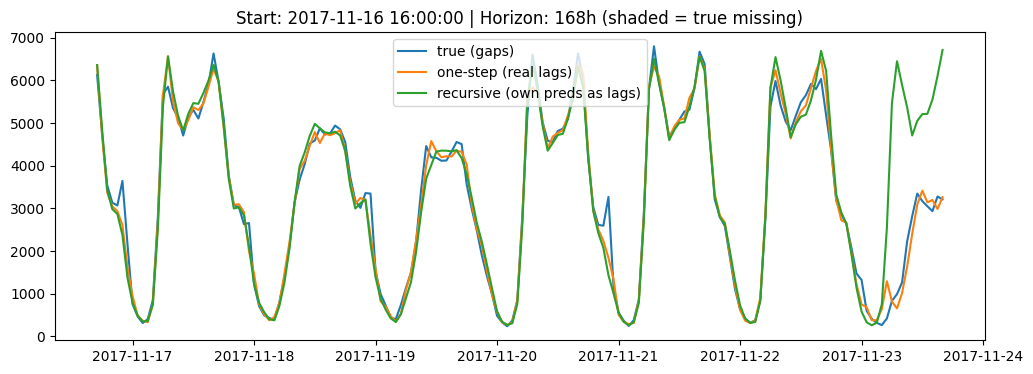

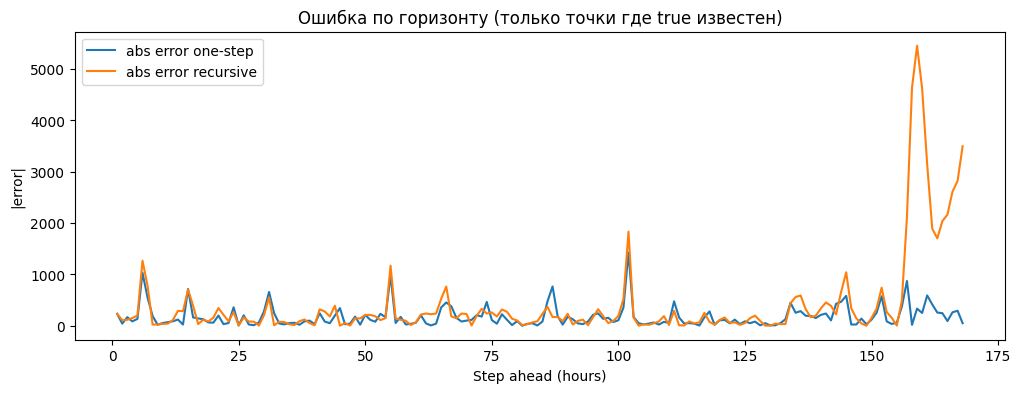

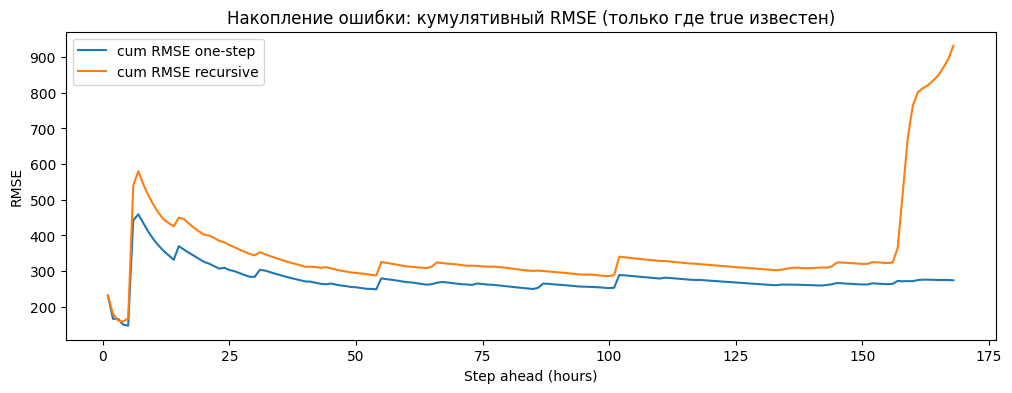

In [ ]:
y_true = df["traffic_volume"].reindex(pred_rec.index)

plt.figure(figsize=(12,4))

missing = y_true.isna()
if missing.any():
    grp = (missing != missing.shift()).cumsum()
    for _, part in missing.groupby(grp):
        if part.iloc[0]:
            plt.axvspan(part.index[0], part.index[-1], alpha=0.15)

plt.plot(y_true.index, y_true.values, label="true (gaps)")
plt.plot(pred_1s.reindex(pred_rec.index).index,
         pred_1s.reindex(pred_rec.index).values,
         label="one-step (real lags)")
plt.plot(pred_rec.index, pred_rec.values, label="recursive (own preds as lags)")

plt.title(f"Start: {start_time} | Horizon: {H}h (shaded = true missing)")
plt.legend()
plt.show()


mask = y_true.notna()
y_true_m = y_true[mask]
pred_1s_m = pred_1s.reindex(pred_rec.index)[mask]
pred_rec_m = pred_rec[mask]

err_1s  = (pred_1s_m - y_true_m).abs().values
err_rec = (pred_rec_m - y_true_m).abs().values
steps = np.arange(1, len(err_rec)+1)

plt.figure(figsize=(12,4))
plt.plot(steps, err_1s, label="abs error one-step")
plt.plot(steps, err_rec, label="abs error recursive")
plt.title("Ошибка по горизонту (только точки где true известен)")
plt.xlabel("Step ahead (hours)")
plt.ylabel("|error|")
plt.legend()
plt.show()

rmse_1s  = np.sqrt(np.cumsum((pred_1s_m - y_true_m).values**2) / steps)
rmse_rec = np.sqrt(np.cumsum((pred_rec_m - y_true_m).values**2) / steps)

plt.figure(figsize=(12,4))
plt.plot(steps, rmse_1s, label="cum RMSE one-step")
plt.plot(steps, rmse_rec, label="cum RMSE recursive")
plt.title("Накопление ошибки: кумулятивный RMSE (только где true известен)")
plt.xlabel("Step ahead (hours)")
plt.ylabel("RMSE")
plt.legend()
plt.show()


## Вывод по графикам

Общий вывод следующий - модель неплохо рекурсивно прогнозирует поведение трафика. Лишь под конец недели случается резкое рассхождение с реальными данными, сопровождающееся резким выбросом кумулятивной ошибки. Это явление требует особого рассмотрения, т.к. в основном кумулятивная ошибка остаётся на одном уровне, а не увеличивается с каждым часом.